# Logistic Regression for Survival Probability 

In [177]:
import numpy as np
import matplotlib.pyplot as plt
import mscl_utils as mscl
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import tqdm

colors = mscl.set_plotting_style()
%matplotlib inline

In [224]:
# Load the data. 
data = pd.read_csv('data/201707_survival_data.csv')
# data = data[data['sd'] != 'sd1']
df = data.drop(['sd', 'area', 'intensity'], axis=1)
df['survival'] = df['survival'].astype(int)
# df = df[df['channel_density'] >= 0]

df.head()

,flow_rate,survival,channel_density
0,0.02,0,19.458879
1,0.02,0,23.907528
2,0.02,0,30.736799
3,0.02,0,32.122569
4,0.02,0,19.458879


Use statsmodels to perform the logit regression. 

In [225]:
formula = 'survival ~ channel_density'
model = smf.logit(formula, data=df)
results = model.fit(disp=False)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survival   No. Observations:                 2660
Model:                          Logit   Df Residuals:                     2658
Method:                           MLE   Df Model:                            1
Date:                Thu, 03 Aug 2017   Pseudo R-squ.:                 0.03822
Time:                        16:48:10   Log-Likelihood:                -1748.2
converged:                       True   LL-Null:                       -1817.7
                                        LLR p-value:                 4.552e-32
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.1636      0.088    -13.238      0.000      -1.336      -0.991
channel_density     0.0203      0.002     11.450      0.000       0.017       0.024
===================================================================================
"""

Fit it to channel range of our choice. 

In [226]:
channels = np.linspace(0, 150, 1000)
# channels = np.logspace(0, 3, 500)
result_df = pd.DataFrame(channels, columns=['channel_density'])
probs = results.predict(result_df)

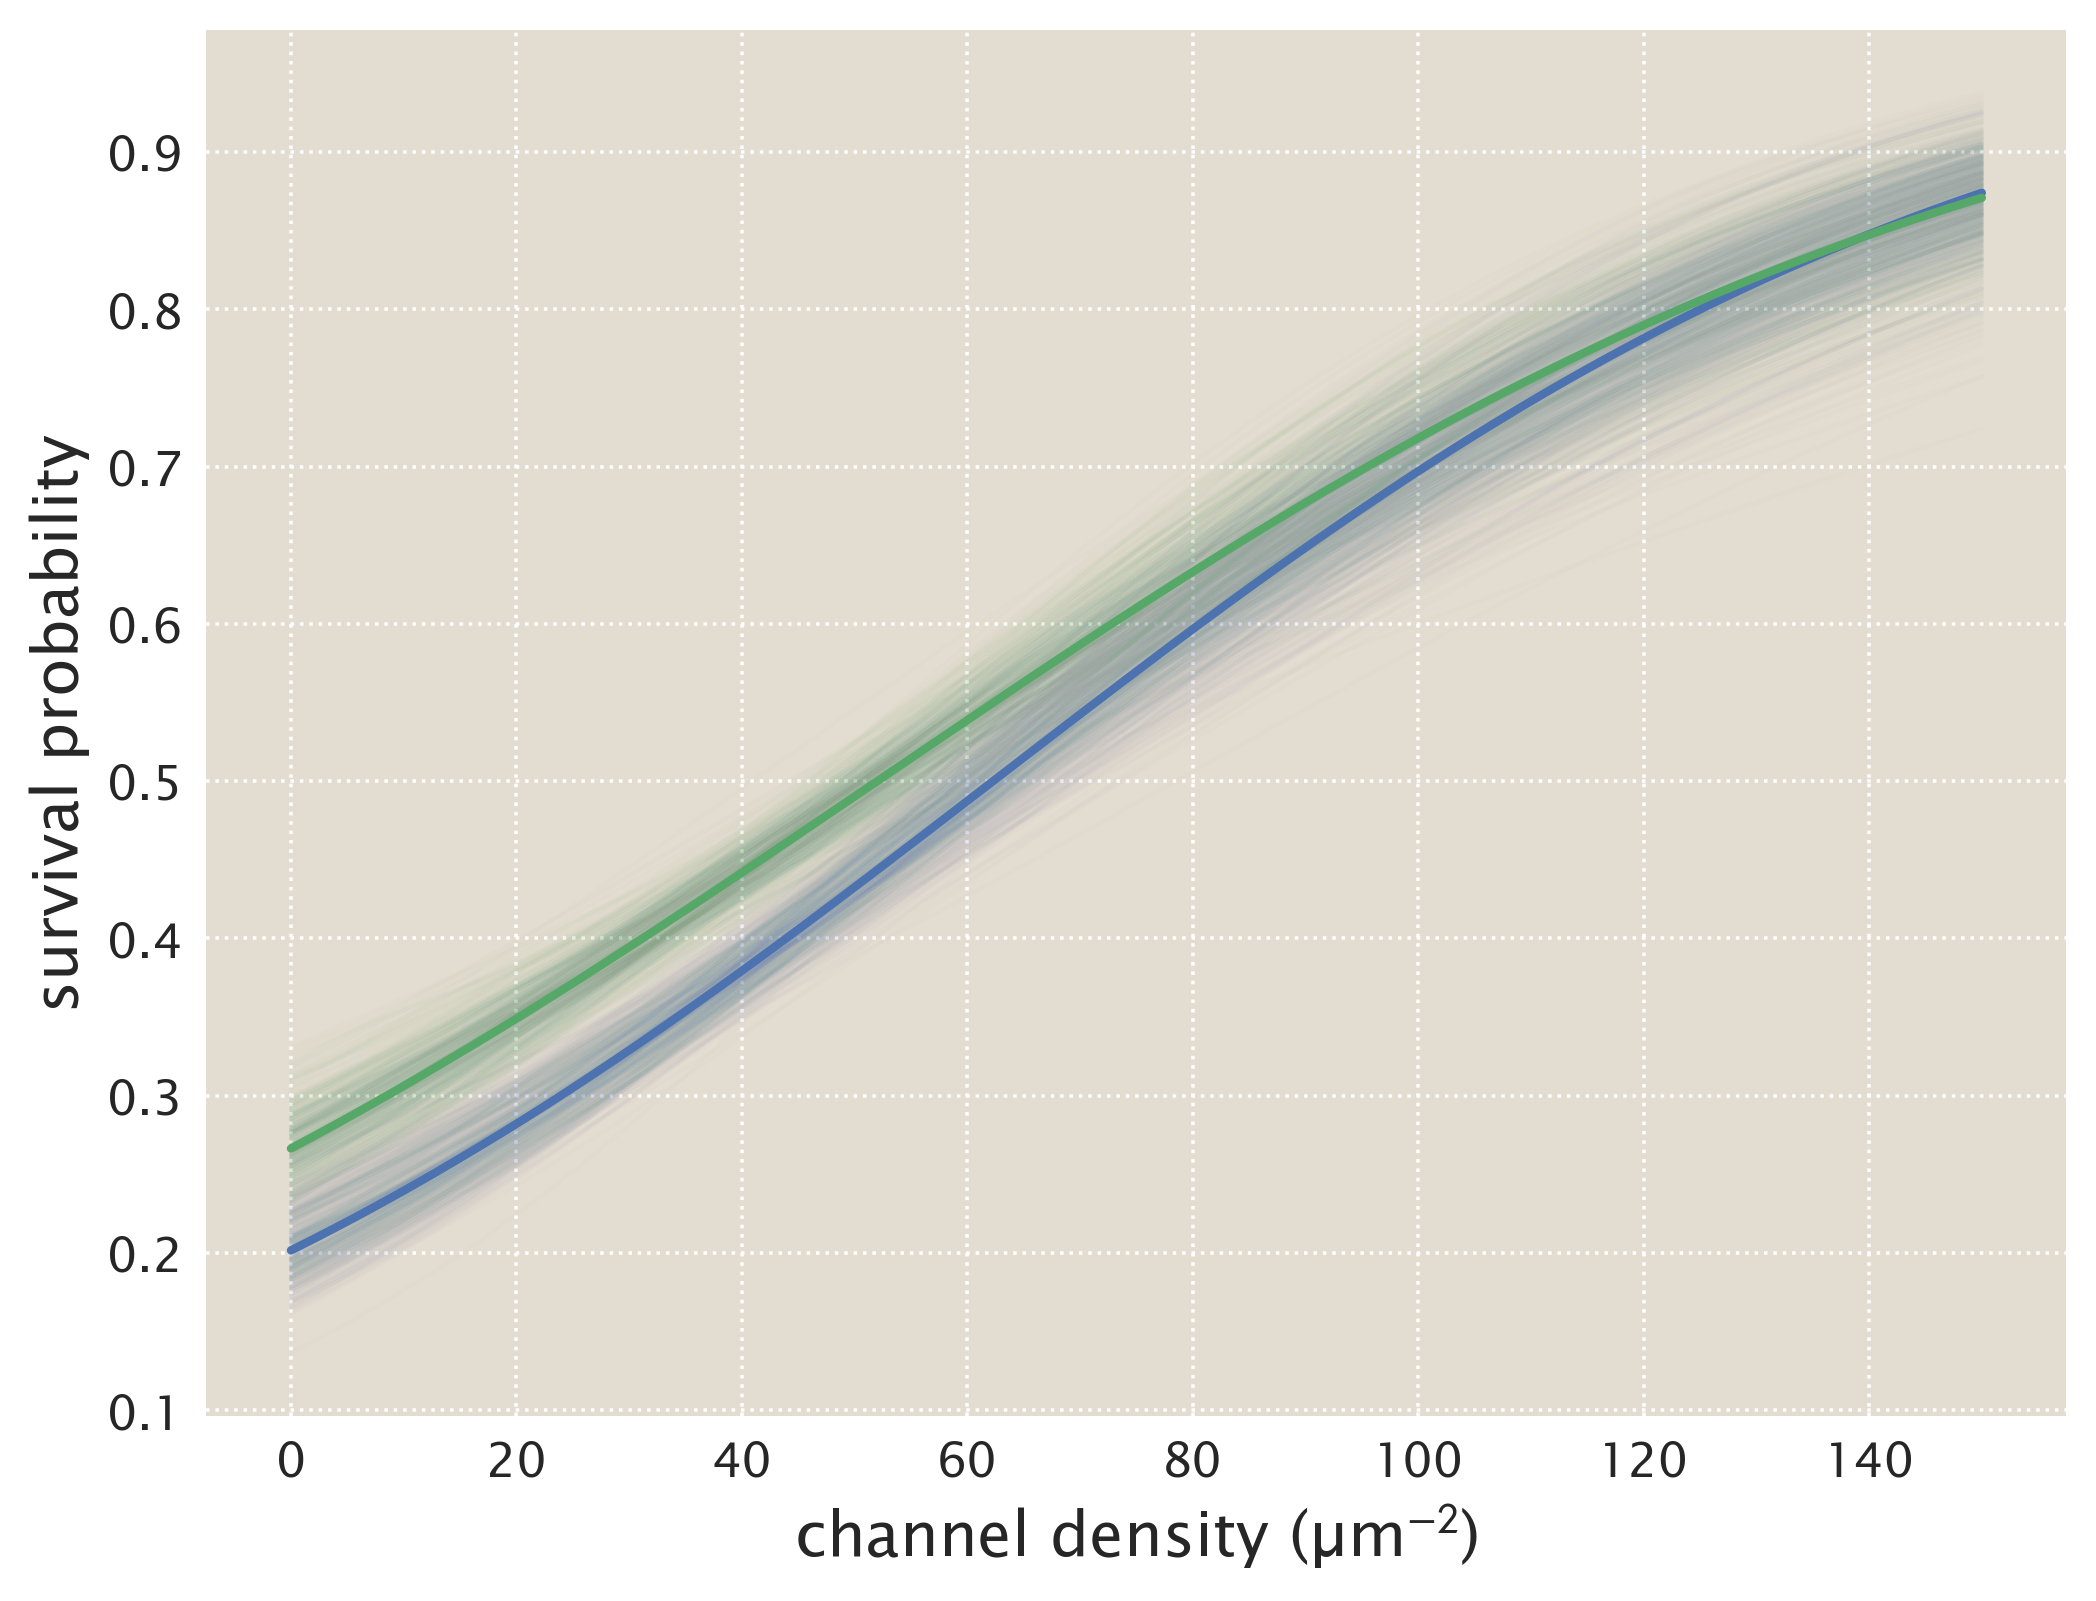

In [227]:
grouped = df.groupby('survival')
sns.set_palette('deep', color_codes=True)
colors = {1: 'r', 0: 'k'}
# for g, d in grouped:
#     plt.plot(d['channel_density'], d['survival'], '.', color=colors[g])  


# Perform the replicates. 
df.loc[(df['flow_rate'] < 1), 'flow_group'] = 'slow'
df.loc[(df['flow_rate'] >= 1), 'flow_group'] = 'fast'

grouped = df.groupby('flow_group')
colors = {'slow': 'g', 'fast': 'b'}

_probs = []
_results = []
for g, d in grouped:
    for i in range(500):
        sample = d.sample(len(d), replace=True)
        model = smf.logit(formula, data=sample)
        results = model.fit(disp=False)
        probs = results.predict(result_df)
        plt.plot(channels, probs, '-', color=colors[g], lw=1, alpha=0.01)
    model = smf.logit(formula, data=d)
    results = model.fit(disp=False)
    probs  = results.predict(result_df)
    _results.append(results)
    _probs.append(probs)
    plt.plot(channels, probs, '-', color=colors[g], zorder=100)
plt.xlabel('channel density (µm$^{-2}$)', fontsize=15)
plt.ylabel('survival probability', fontsize=15)

In [205]:
_results[1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survival   No. Observations:                 1406
Model:                          Logit   Df Residuals:                     1404
Method:                           MLE   Df Model:                            1
Date:                Thu, 03 Aug 2017   Pseudo R-squ.:                 0.03317
Time:                        13:59:44   Log-Likelihood:                -936.24
converged:                       True   LL-Null:                       -968.36
                                        LLR p-value:                 1.104e-15
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.9944      0.117     -8.469      0.000      -1.225      -0.764
channel_density     0.0191      0.002      7.812      0.000       0.014       0.024
===================================================================================
"""

Also using fitting flow rate.

## Comparison with binning. 


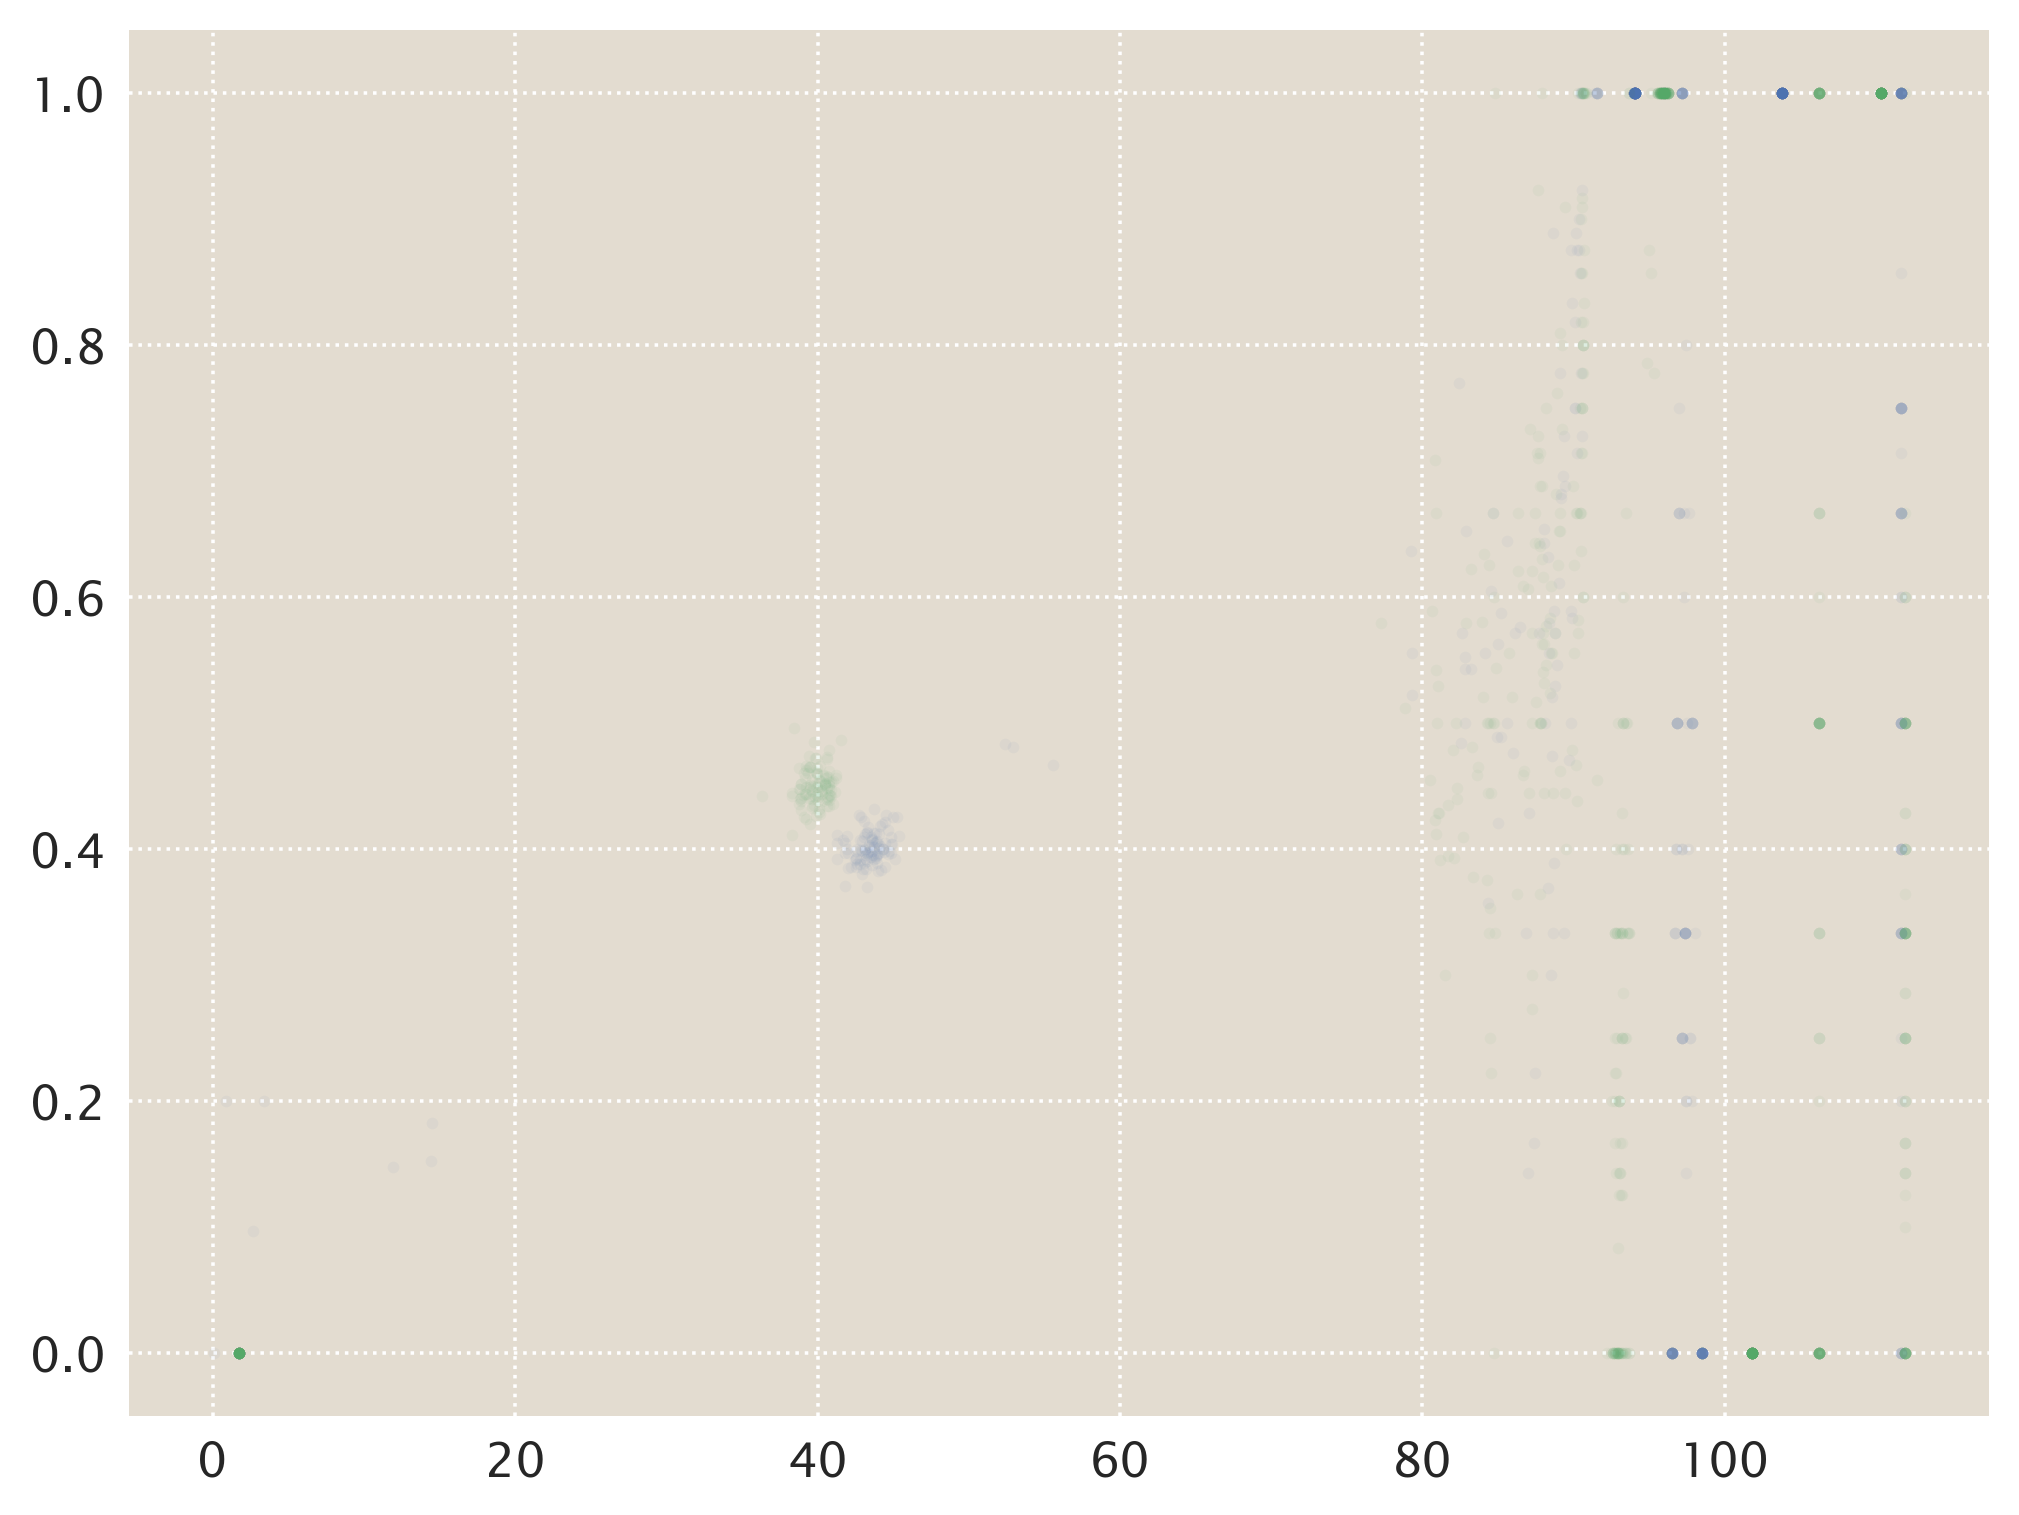

In [249]:
# make a copy of the dataframe to manipulate.
data = data[data['channel_density'] > 0]
df_cop = data.copy()

 # Group flow rates into 'slow' and 'fast'
_groups = df_cop['flow_rate'] < 1.0 
groups = ['slow' if x == True else 'fast' for x in _groups]
df_cop.insert(np.shape(df_cop)[1], 'flow_group', groups)
    
# Perform the binning by consolidating the number of cells. 
channel_bin = 1  
its = 100
for k in range(its):
#     channel_bin = _bins[k] 

    df_bin = df_cop.sample(len(df_cop), replace=True)
    bins = np.arange(df_bin['channel_density'].min(), df_bin['channel_density'].max(), channel_bin)
    # df_bin.insert(np.shape(df_bin)[1], 'fluo_bin', 0)
    for i in range(0, len(bins) - 1): 
        df_bin.loc[(df_bin['channel_density'] >= bins[i]) &\
           (df_bin['channel_density'] < bins[i+1]), 'bin_no'] = int(i)

    # Group by the flow rate and bin_no
    grouped = df_bin.groupby(['flow_group', 'bin_no'])
    g_dict = {'slow': 0, 'fast': 1}
    rev_dict = {0:'slow', 1:'fast'}
    events = [{}, {}]
    for g, d in grouped:
        events[g_dict[g[0]]][g[1]]= len(d)

    min_cells = 100
    changed_keys = [{}, {}]
    for i, flow in enumerate(events):
        low_keys = []
        for k in flow.keys():
            if flow[k] < min_cells:
                low_keys.append(k)

        # Separate them sequentially
        split_keys = []
        inds = np.where(np.diff(low_keys) > 1)[0]
        if len(inds) > 0:
            for j in range(len(inds)):
                if j==0:
                    split_keys.append(low_keys[: inds[j] + 1])
                elif i==(len(inds) - 1):
                    split_keys.append(low_keys[inds[j-1]+1: inds[j]+1])
                    split_keys.append(low_keys[inds[j]+1: ])
                else:
                    split_keys.append(low_keys[inds[j-1]+1: inds[j]+1])
        else:
            split_keys = [low_keys]
        for rng in split_keys:
            n_cells = np.sum(flow[z] for z in rng)
            if np.sum(flow[z] for z in rng) >= min_cells: 
                for z in rng:
                    changed_keys[i][z] = np.min(rng)

            else:
                for z in rng:
                    changed_keys[i][z] = np.min(rng) - 1

        # Change the bin number in the DataFrame. 
        for k in changed_keys[i].keys():
            df_bin.loc[(df_bin['flow_group'] == rev_dict[i]) & (df_bin['bin_no']== k),\
                   'bin_no'] = changed_keys[i][k]

    grouped = df_bin.groupby('flow_group')
    colors = sns.color_palette('deep')
    columns = ['flow_group', 'bin_number', 'channel_density', 'survival_probability', 'survivor_error']
    df_bins = []
    for g, d in grouped: 
        # Group the data by the bin number. 
        _grouped = d.groupby('bin_no')

        for _g, _d in _grouped:
            n = np.sum(_d['survival'])
            N = len(_d)  
            mean_chan = np.mean(_d['channel_density'])
            surv_frac = np.sum(_d['survival']) / len(_d)
            surv_error = np.sqrt(n * (N-n)/ N**3)
            df_bins.append(pd.DataFrame([g, _g, mean_chan, surv_frac, surv_error]).T)
    prob_df_bin = pd.concat(df_bins)        
    prob_df_bin.columns = columns
    grouped = prob_df_bin.groupby('flow_group')
    colors = {'slow': 'g', 'fast': 'b'}
    for g, d in grouped:
#         plt.errorbar(d.channel_density, d.survival_probability, d.survivor_error, linestyle='none',
#                     fmt='o', color=colors[g], alpha=0.5)
        plt.plot(d.channel_density, d.survival_probability, '.', lw=1, alpha=0.05, 
                color=colors[g])
   
#     plt.plot(channels, _probs[0], 'b-')
#     plt.plot(channels, _probs[1], 'g-')

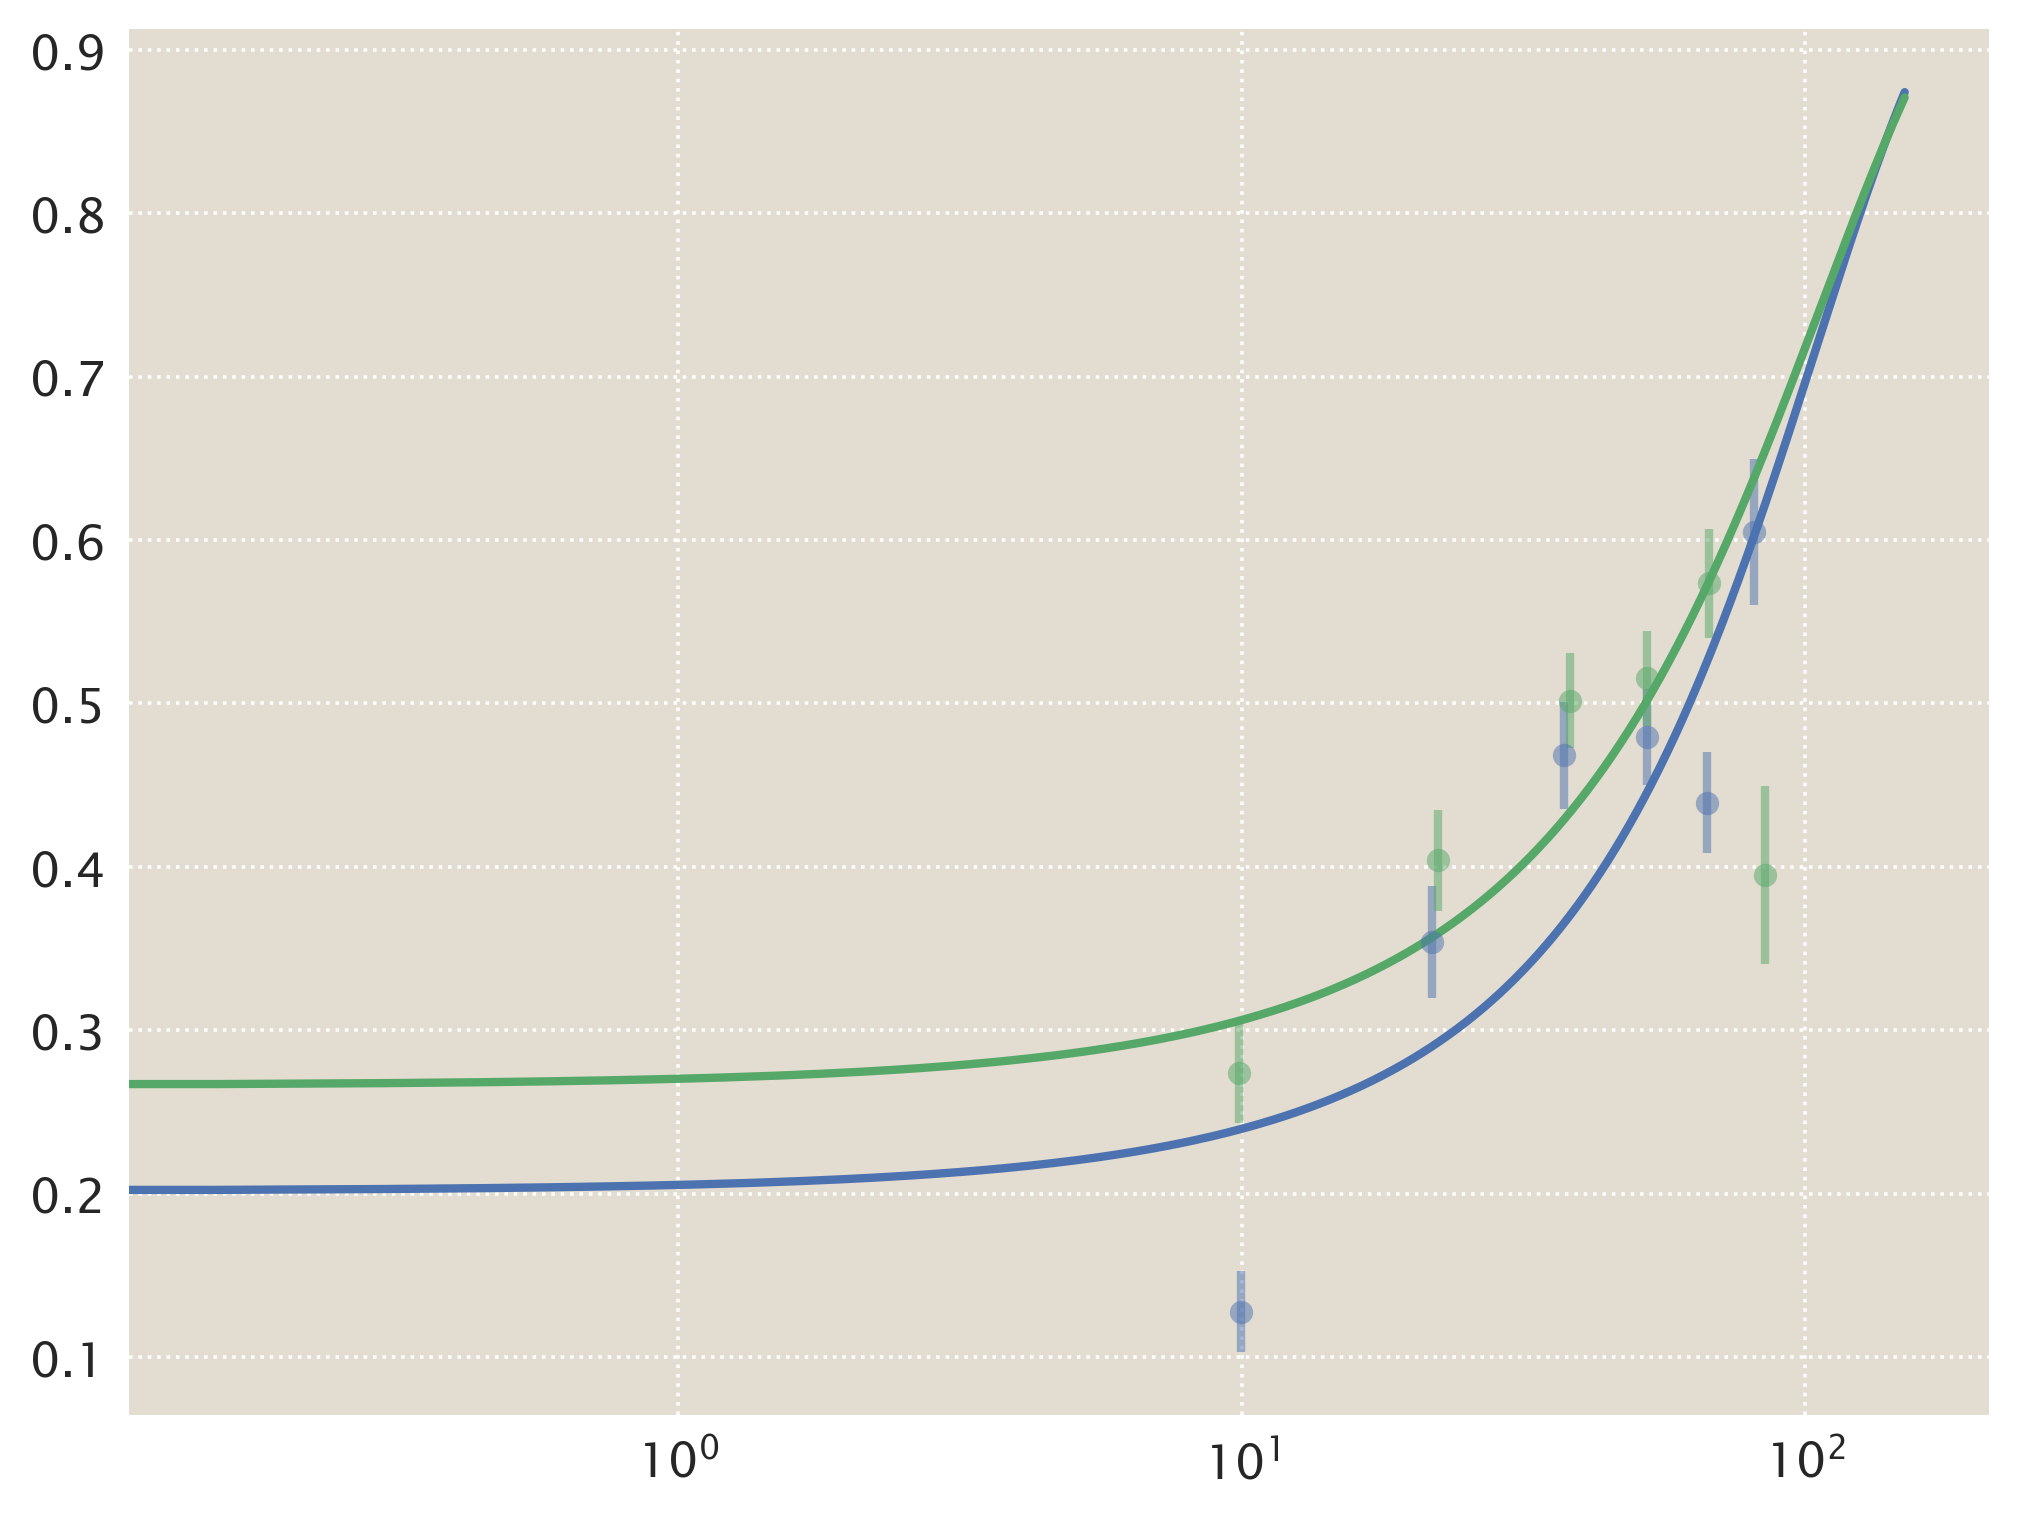

In [241]:
grouped = prob_df_bin.groupby('flow_group')
colors = {'slow': 'g', 'fast': 'b'}
for g, d in grouped:
    plt.errorbar(d.channel_density, d.survival_probability, d.survivor_error, linestyle='none',
                fmt='o', color=colors[g], alpha=0.5)
plt.xscale('log') 
plt.plot(channels, _probs[0], 'b-')
plt.plot(channels, _probs[1], 'g-')

In [208]:
bins

array([-24.52416021,  49.47583979])